In [51]:
import os
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [52]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [53]:
def parse_structure_names(DATA_PATH=DATA_DIR):
    structure_names = []
    for filename in os.listdir(DATA_DIR):
        ext = ".json"
        if filename.endswith(ext):
            structure_names.append(filename[: -len(ext)])
            
    return structure_names

In [54]:
#structure_names = ["Ge-1_Se-1", "Ge-1_Te-1", "Ge-1_Sb-1", "Si-1_C-1"]
structure_names = parse_structure_names()
encoding = "atomic"

In [55]:
df = pd.concat([pd.read_csv(os.path.join(DATA_DIR, f"{struct_name}_{encoding}.csv"), index_col=0) for struct_name in structure_names])

In [56]:
cols_raw = list(df.columns)
cols_trash = ['converged', 'accuracy']
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [57]:
X_raw = df[cols_dependent]
y_raw = np.abs(df[cols_independent]).squeeze()

In [58]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,Ag,Al,Ar,As,Au,B,Ba,...,Ti,Tl,Tm,V,W,Xe,Y,Yb,Zn,Zr
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.0,8708.0,8708.000000,8708.0,8708.0,8708.000000,...,8708.000000,8708.000000,8708.0,8708.0,8708.0,8708.0,8708.000000,8708.0,8708.0,8708.0
mean,244.859899,0.230641,58.209692,0.037724,0.0,0.0,0.036174,0.0,0.0,0.037781,...,0.037724,0.027102,0.0,0.0,0.0,0.0,0.037552,0.0,0.0,0.0
std,89.306459,0.145985,23.683528,0.132064,0.0,0.0,0.129538,0.0,0.0,0.132156,...,0.132064,0.113215,0.0,0.0,0.0,0.0,0.131787,0.0,0.0,0.0
min,100.000000,0.100000,20.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
25%,180.000000,0.125000,40.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
50%,260.000000,0.166667,60.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
75%,340.000000,0.250000,80.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
max,380.000000,0.500000,100.000000,0.500000,0.0,0.0,0.500000,0.0,0.0,0.500000,...,0.500000,0.500000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0


# Train-Test-Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [60]:
# functions such that f(x) != 0 and f(+inf) = 0
functions_set_1 = [
    lambda x: np.exp(-x),
    lambda x: 1 / (1+x),
    lambda x: 1 / (1+x)**2,
    lambda x: np.cos(x) * np.exp(-x),
]

# functions such that f(x) = 0 and f(+inf) = 0
functions_set_2 = [
    lambda x: x*np.exp(-x),
    lambda x: x / (1+x)**2,
    lambda x: x / (1+x)**3,
    lambda x: np.sin(x) * np.exp(-x),
]

linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', FeatureUnion(
    [
        (f"fun_{j}", FunctionTransformer(lambda X : f(X[:,:3]))) for j, f in enumerate(functions_set_1 + functions_set_2)
    ] + [
        (f"fun_{j}_col_{col}_1", FunctionTransformer(lambda X : f(X[:,:3] * X[:,i][:, None]))) for j, f in enumerate(functions_set_1) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ] + [
        (f"fun_{j}_col_{col}_2", FunctionTransformer(lambda X : f(X[:,3:] * X[:,i][:, None]))) for j, f in enumerate(functions_set_2) for i, col in enumerate(["ecutrho", "kpoints", "ecutwfc"])
    ])),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [61]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [62]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [63]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### Packing them together to reduce code size

In [64]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [ ]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training Gradient Boosting...


# Model evaluation

In [ ]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

# Visualization

In [ ]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')
PLOTPATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "plots/delta_E_regression/toy_comparison.png")
plt.savefig(PLOTPATH)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))

## Predict $\log(\Delta E)$ instead of $∆E$

In [18]:
def log_transform(y, miny, eps=10E-15):
    return np.log(y - miny + eps)

def inv_log_transform(logy, miny, eps=10E-15):
    return np.exp(logy) + miny - eps

miny = float(np.min(y_raw))
maxy = float(np.max(y_raw))

y_raw_s = np.array(y_raw.squeeze())
miny2 = np.sort(list(set(list(y_raw_s))))[1]
eps = (miny2 - miny)/10

    

logy_raw = log_transform(y_raw, miny, eps)
X_train, X_test, logy_train, logy_test = train_test_split(
    X_raw, logy_raw,
    test_size=0.2,
    random_state=42
)

In [19]:
linear_log_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

In [20]:
rf_log_model = RandomForestRegressor()

In [21]:
gb_log_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [22]:
xgb_log_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

In [23]:
models = {
    "Augmented Linear Regression - Log": linear_log_augmented_model,
    "Random Forest - Log": rf_log_model,
    "Gradient Boosting - Log": gb_log_model,
    "XGBoost - Log": xgb_log_model,
}

In [24]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, logy_train)
    print("Done!\n")

Training Augmented Linear Regression - Log...
Done!

Training Random Forest - Log...
Done!

Training Gradient Boosting - Log...
Done!

Training XGBoost - Log...
Done!



In [25]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    logy_pred_train = model.predict(X_train)
    y_pred_train = inv_log_transform(logy_pred_train.squeeze(), miny, eps)
    logy_pred_test = model.predict(X_test)
    y_pred_test = inv_log_transform(logy_pred_test.squeeze(), miny, eps)
    
    y_train = inv_log_transform(logy_train.squeeze(), miny, eps)
    y_test = inv_log_transform(logy_test.squeeze(), miny, eps)

    mse_test = mean_squared_error(logy_test, logy_pred_test)
    mse_train = mean_squared_error(logy_train, logy_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mape_test = mean_absolute_percentage_error(logy_test, logy_pred_test)
    mape_train = mean_absolute_percentage_error(logy_train, logy_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression - Log...
MSE:	train:1.9844E+00	test:2.3247E+00
MSE:	train:3.8227E-02	test:1.9394E-02
MAPE:	train:6.7830E-01	test:5.6533E-01
Done!

Evaluating Random Forest - Log...
MSE:	train:1.5586E-02	test:3.2214E-01
MSE:	train:9.7057E-08	test:1.7979E-07
MAPE:	train:3.4948E-03	test:1.1487E-02
Done!

Evaluating Gradient Boosting - Log...
MSE:	train:1.0436E-01	test:3.5695E-01
MSE:	train:1.2260E-03	test:1.8546E-03
MAPE:	train:7.7731E-02	test:1.0312E-01
Done!

Evaluating XGBoost - Log...
MSE:	train:6.7194E-04	test:2.0443E-01
MSE:	train:1.2034E-06	test:3.3997E-05
MAPE:	train:3.6170E-03	test:1.9077E-02
Done!



Text(0.5, 0, 'ecutwfc')

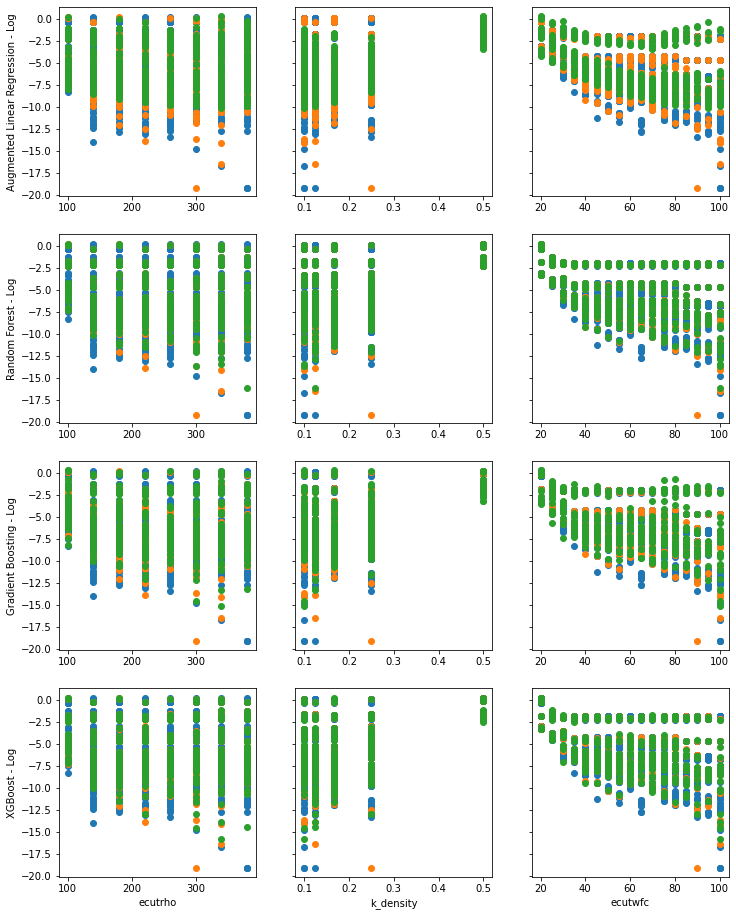

In [26]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], logy_train)
        ax[j,i].scatter(X_test[col], logy_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

# Find best parameters for a given error

In [70]:
from scipy.optimize import NonlinearConstraint, LinearConstraint, minimize, shgo, differential_evolution

In [71]:
def sanitize_input(x):
    return np.array([int(round(x_i)) for x_i in x])

def delta_E_prediction(x, model):
    # get Ge and Te column index
    Ge_idx = X_raw.columns.get_loc("Ge")
    Te_idx = X_raw.columns.get_loc("Te")

    input = np.zeros(X_raw.shape[1])
    input[0:3] = sanitize_input(x)
    input[1] = 1 / input[1]
    input[Ge_idx] = 0.5
    input[Te_idx] = 0.5
    input = pd.DataFrame(input.reshape(1, -1), columns=X_raw.columns)
    return model.predict(input)[0]

def complexity(x):
    # we have to get the right formula for the complexity
    ecutrho = x[0]
    k_density = 1/x[1]
    ecutwfc = x[2]
    return ecutrho**3 + k_density**2 + ecutwfc

### Minimize complexity using $\Delta E$ regressors

In [72]:
x_0 = [100, 10, 100]
max_delta_E = 1e-3
model = xgb_model
model_pred_func = lambda x: delta_E_prediction(x, model)

nonlin_constraint = NonlinearConstraint(lambda x: delta_E_prediction(x, model), 0, max_delta_E)
# lin_constraint = LinearConstraint(A=np.eye(3), lb=np.array([1,0,1]), ub=np.array([1000,0.5,1000]))

print(delta_E_prediction(x_0, model))

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[(1,1000), (1, 100), (1,1000)],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(delta_E_prediction(res.x, model))

# codes below don't work

# minimize(complexity, x_0, constraints=[nonlin_constraint, lin_constraint])

# res = minimize(complexity, x0=x_0, bounds=[(1,1000), (1e-16,0.5), (1,1000)],
#     constraints=({'type': 'ineq', 'fun': lambda x: delta_E_prediction(x, model)},
#                  {'type': 'ineq', 'fun': lambda x: -delta_E_prediction(x, model) + max_delta_E}),
#     options={'maxiter': 1000},
# )


0.011734806
     fun: 1706699.4578881722
 message: 'Optimization terminated successfully.'
    nfev: 1632
     nit: 35
 success: True
       x: array([119.50013103,   2.95993234, 203.85542698])
[120   3 204]
0.00047621073


### Minimize complexity using $log(\Delta E)$ regressors

In [73]:
max_delta_E = 1e-5
model = xgb_log_model
model_pred_func = lambda x: inv_log_transform(delta_E_prediction(x, model), miny, eps)

mu = 1e100
pen_func = lambda x: complexity(x) + mu * max(model_pred_func(x) - max_delta_E, 0) / max_delta_E
res = differential_evolution(
    pen_func,
    bounds=[(1,1000), (1, 100), (1,1000)],
    seed=0,
)

print(res)
print(sanitize_input(res.x))

print(model_pred_func(res.x))

     fun: 21835678.665638622
 message: 'Optimization terminated successfully.'
    nfev: 1092
     nit: 23
 success: True
       x: array([279.50277553,  68.13606991, 418.30775957])
[280  68 418]
4.546092839063931e-06
